# ZINC20 (700M) subset with similarity threshold

This notebook demonstrates how to use the `OnlineDiversityPicker` class to select a diverse subset of molecules from the ZINC20 database. It ensures that the Tanimoto distance, defined as 

$$ \text{[Tanimoto distance]} = 1 - \text{[Tanimoto coefficient]}, $$

between any two molecules is at least 0.75. The exact number of molecules in the subset is not fixed in advance. The user specifies the maximum size of the subset according to their computational resources and the desired processing speed.

Moreover, the notebook presents methods for managing large datasets that cannot be loaded into memory. The `OnlineDiversityPicker` class is built to process large datasets by working in an online manner and demonstrates linear scaling with dataset size.

In [1]:
import os
import warnings
from concurrent.futures import ProcessPoolExecutor
from pathlib import Path

import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from rdkit import RDLogger
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import rdFingerprintGenerator
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

from moll.metrics import one_minus_tanimoto
from moll.picking import OnlineDiversityPicker
from moll.utils import group_files_by_size

Warnings are ignored

In [2]:
warnings.filterwarnings("ignore")
RDLogger.DisableLog("rdApp.*")

Fingerprint properties

In [3]:
FINGERPRINT_SIZE = 2048
FINGERPRINT_RADIUS = 2
FINGERPRINT_FOLD = 2

Molecules in batch

In [4]:
BATCH_SIZE = 30_000

Directory with SMILES files

In [5]:
ROOT_DIR = "/data/zinc-smiles/"

Number of parallel jobs

In [6]:
N_WORKERS = os.cpu_count() - 4  # leave some cores free
N_WORKERS

20

## Analyze file sizes and number of molecules

In [7]:
SMILES_FILES = list(Path(ROOT_DIR).glob("*.smi"))
N_SMILES_FILES = len(SMILES_FILES)
N_SMILES_FILES

10456

Take a look at the file sizes

In [8]:
file_sizes = pd.Series({f.name: f.stat().st_size for f in SMILES_FILES})  # in bytes
file_sizes = file_sizes / 1024 / 1024  # in MB

File sizes vary significantly:

In [9]:
file_sizes.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])

count    10456.000000
mean         4.167789
std         42.681754
min          0.000040
10%          0.000215
25%          0.000958
50%          0.008106
75%          0.086464
90%          0.908896
max       1430.434464
dtype: float64

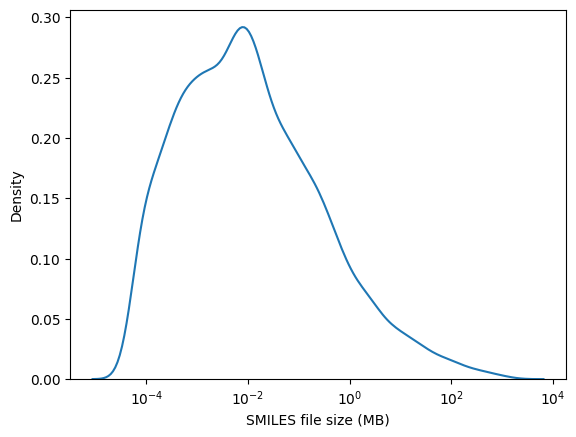

In [10]:
ax = sns.kdeplot(data=file_sizes, log_scale=True)
ax.set_xlabel("SMILES file size (MB)")
plt.show()

Calculate total number of molecules (first line may or may not be a header, some molecules may be invalid)

In [11]:
N_LINES = sum(1 for f in SMILES_FILES for _ in f.read_text().splitlines())
N_LINES

694449769

## Define necessary functions

We will use PyTorch's Dataset and DataLoader classes to load molecules in parallel.

In [12]:
class SmilesDataset(Dataset):
    """
    Dataset of multiple SMILES files. Fingerprints and labels are generated on the fly.
    """

    def __init__(
        self,
        smi_files: list[Path],
        fp_size: int,
        fp_radius: int,
        fp_fold: int,
        n_workers: int = N_WORKERS,
        drop_first_line: bool = True,
        shuffle: bool = True,
        seed: int = 42,
    ):
        self.smi_files = smi_files
        self.n_workers = n_workers
        self.drop_first_line = drop_first_line

        self.fp_fold = fp_fold
        self.fp_size = fp_size
        self.fp_radius = fp_radius

        # RDKit fingerprint generator cannot be used with ProcessPoolExecutor even as
        # a class attribute. It will be created after the dataset is loaded, on first use.
        self.fp_gen = None

        # Data is stored in memory as a DataFrame
        self.shuffle = shuffle
        self.seed = seed
        self.df = self.load_data()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        label = (row.stem, row.line_no, row.id)
        try:
            mol = Chem.MolFromSmiles(row.smiles)
            fp = self.mol_to_fp(mol)
        except Exception:
            print(f"Ignoring SMILES: {row.smiles} {label}")
            fp = None
        return fp, label

    def mol_to_fp(self, mol):
        """
        Convert RDKit molecule to Morgan fingerprint.
        """
        # Create fingerprint generator on first use
        if self.fp_gen is None:
            self.fp_gen = rdFingerprintGenerator.GetMorganGenerator(
                radius=self.fp_radius, fpSize=self.fp_size
            )

        fp = self.fp_gen.GetFingerprintAsNumPy(mol)
        if self.fp_fold > 1:
            fp = np.bitwise_or.reduce(fp.reshape(self.fp_fold, -1))
        return np.array(fp, dtype=bool)  # store on CPU

    def load_smi_file(self, smi_file):
        df = pd.read_csv(
            smi_file,
            sep="\s",
            names=["smiles", "id"],
            header=None,
        )

        if self.drop_first_line:
            df.drop(0, inplace=True)

        df["stem"] = Path(smi_file).stem
        df.reset_index(inplace=True, names=["line_no"])
        return df

    def load_data(self):
        with ProcessPoolExecutor(max_workers=self.n_workers) as executor:
            gen = executor.map(self.load_smi_file, self.smi_files)
            data = pd.concat(list(gen), ignore_index=True)

        if self.shuffle:
            data = data.sample(frac=1, random_state=self.seed).reset_index(drop=True)

        return data

In [13]:
def collate_fn(data):
    """
    Collate fingerprints and labels into a single batch.
    """
    data = filter(lambda fp_and_label: fp_and_label[0] is not None, data)
    fps, labels = zip(*data)
    fps = np.array(fps, dtype=bool)
    return fps, labels

## Group files into batches by size

To prevent storing all data in memory, files will be grouped into **metabatches** 🫣 of nearly equal size, ensuring that each parallel job completes in approximately the same amount of time.







In [14]:
SMILES_FILES_METABATCHES = group_files_by_size(SMILES_FILES, 20)

Batch sizes in GB:

In [15]:
batch_sizes_gb = [
    (len(batch), sum(f.stat().st_size for f in batch) / 1024 / 1024 / 1024)
    for batch in SMILES_FILES_METABATCHES
]

pd.DataFrame(batch_sizes_gb, columns=["n_files", "size_GB"])

,n_files,size_GB
0,10018,2.128810
1,182,2.130854
2,80,2.138785
3,46,2.173304
4,29,2.148427
5,21,2.129370
6,17,2.226583
7,13,2.330579
8,10,2.267789
9,8,2.326652


Looks good. We need a lot of RAM to store labels and fingerprints. Metabatch size of ~2GB is OK.

## Pick molecules

In [16]:
picker = OnlineDiversityPicker(
    capacity=50_000,  # limit the number of picked molecules
    k_neighbors=300,
    similarity_fn=one_minus_tanimoto,
    threshold=0.75,  # distance threshold
)

Start picking:

In [17]:
%%time

# Define progress bars
progress_bar_lines = tqdm(total=N_LINES, desc="Lines processed: ")
progress_bar_accepted = tqdm(total=picker.capacity, desc="Were accepted: ")

# Iterate over metabatches of SMILES files
for smi_files in tqdm(SMILES_FILES_METABATCHES, desc="SMILES batch: "):
    # For each metabatch, create a dataset
    dataset = SmilesDataset(
        smi_files,
        fp_size=FINGERPRINT_SIZE,
        fp_radius=FINGERPRINT_RADIUS,
        fp_fold=FINGERPRINT_FOLD,
    )

    # ... and a dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        num_workers=N_WORKERS,
        collate_fn=collate_fn,
    )

    # Iterate over batches of fingerprints and corresponding labels
    for fps, labels in dataloader:
        # Pass fingerprints to the picker
        fps = jnp.array(fps, dtype=bool)
        n_accepted = picker.update(fps, labels)

        # Update progress bars
        progress_bar_lines.update(len(fps))  # some lines may be skipped due to errors
        progress_bar_accepted.update(
            n_accepted
        )  # accepted points may be overwritten later

CPU times: user 1d 1h 20min 23s, sys: 5h 25min 24s, total: 1d 6h 45min 48s
Wall time: 21h 3min 14s


## Save results

OK. We've finished. Let's save the results

In [ ]:
labels_picked = pd.DataFrame(picker.labels, columns=["file_stem", "line_no", "id"])
labels_picked.to_hdf("labels_picked.h5", "labels_picked")

## What's next?

Chosen parameters and strategy could be improved.

1. Shuffle the molecules before picking to avoid selecting similar molecules consecutively, which ensures better picker initialization.
2. Lower the threshold to select more molecules, which can (theoretically) increase diversity, you then can run the picker again with smaller capacity to remove the excess.
3. Decrease the picker capacity if you are working with a non-diverse dataset; this can also increase speed.